<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/Census_MLP_Atencao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Wed Aug  5 23:04:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install -q torch_optimizer
import torch_optimizer as optim_

!pip install -q einops
from einops import rearrange, reduce, asnumpy, parse_shape
from einops.layers.torch import Rearrange, Reduce

In [4]:
# Basics
import os
import pandas as pd
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch 
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import quantile_transform

# Scipy
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
manual_seed = 2357

def deterministic(rep=True):
    if rep:
        np.random.seed(manual_seed)
        torch.manual_seed(manual_seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(manual_seed)
            torch.cuda.manual_seed_all(manual_seed)
        torch.backends.cudnn.enabled = False 
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        print(f'Deterministic experiment, seed: {manual_seed}')
    else:
        print('Random experiment')

deterministic()

Deterministic experiment, seed: 2357


In [6]:
try:
    df = pd.read_csv('/content/CensusData.csv');
except:
    !unzip '/content/drive/My Drive/Colab Notebooks/Tabular/36093_54253_bundle_archive.zip'
    df = pd.read_csv('/content/CensusData.csv');

Archive:  /content/drive/My Drive/Colab Notebooks/Tabular/36093_54253_bundle_archive.zip
  inflating: CensusData.csv          


In [7]:
df

,Age,workclass,fnlwgt,education,education-num,Marital-status,Occupation,Relationship,Race,Sex,capital-gain,capital-loss,hours-per-week,native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   Marital-status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  Income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### Troca do Label para numérico

In [9]:
# Verificar a contagem antes
df.Income.value_counts()

 <=50K    24720
 >50K      7841
Name: Income, dtype: int64

In [10]:
# Verificar a contagem depois
df['Income'] = np.where(df['Income'] == ' <=50K', 0, 1)
df.Income.value_counts()

0    24720
1     7841
Name: Income, dtype: int64

### Fazer split entre train e test

In [11]:
df_train, df_test, y_train, y_test = train_test_split(
    df.iloc[:, :-1], 
    df.Income, 
    test_size=0.3)

# retorna para dataframe
df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)
df_train.shape, y_train.shape, df_test.shape, y_test.shape

((22792, 14), (22792,), (9769, 14), (9769,))

In [12]:
df_train

,Age,workclass,fnlwgt,education,education-num,Marital-status,Occupation,Relationship,Race,Sex,capital-gain,capital-loss,hours-per-week,native-country
18991,24,Private,276851,HS-grad,9,Divorced,Protective-serv,Own-child,White,Female,0,1762,40,United-States
9743,33,Self-emp-not-inc,193246,HS-grad,9,Never-married,Exec-managerial,Not-in-family,White,Male,0,0,55,France
23417,50,Private,197322,11th,7,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
25248,45,Private,75673,Assoc-voc,11,Widowed,Adm-clerical,Not-in-family,Asian-Pac-Islander,Female,0,0,40,United-States
12892,27,Private,208725,Assoc-acdm,12,Never-married,Sales,Not-in-family,White,Male,0,0,42,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16432,18,Private,267965,11th,7,Never-married,Sales,Not-in-family,White,Female,0,0,15,United-States
25934,47,Private,503454,12th,8,Never-married,Adm-clerical,Other-relative,Black,Female,0,0,40,United-States
3235,36,Self-emp-not-inc,367020,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,35,United-States
16377,54,Self-emp-not-inc,154785,Bachelors,13,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,50,United-States


### Tratar colunas categóricas

In [13]:
df.dtypes

Age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
Marital-status    object
Occupation        object
Relationship      object
Race              object
Sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
Income             int64
dtype: object

In [14]:
columns   = df.columns.to_list() # todas as colunas
col_types = df.dtypes.to_list()  # todos os tipos de colunas
col_types

[dtype('int64'),
 dtype('O'),
 dtype('int64'),
 dtype('O'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('int64')]

In [15]:
num_cols, cat_cols = [], []
for e in zip(columns, col_types):
    if e[1] == 'object':
        cat_cols.append(e[0])
    else:
        num_cols.append(e[0])

# excluit o target Income da num_cols
num_cols.pop(-1)

print(cat_cols, '\n')
print(num_cols)

['workclass', 'education', 'Marital-status', 'Occupation', 'Relationship', 'Race', 'Sex', 'native-country'] 

['Age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [17]:
def map_categorical_train(df_train, cat_cols):
    df = df_train.copy()
    cat_dims, list_of_dicts = [], []
    
    for col in cat_cols:
        j = 1
        my_dict = {}
        my_dict.update({' ?':0})
        my_dict.update({'UNK':1})

        for e in df[col].value_counts().index.to_list():
            if e not in my_dict.keys():
                j +=1
                my_dict.update({e:j})
        list_of_dicts.append(my_dict)
        cat_dims.append(len(my_dict))

        df[col] = df[col].apply(lambda x: my_dict[x] if x in 
                                my_dict.keys() else my_dict['UNK'])
        
        emb_szs = [(c, min(100, (c+10)//2)) for c in cat_dims]
        cat_emb_dims = [e[0] for e in emb_szs]

    return df, list_of_dicts, emb_szs, cat_dims

#----------------------------------------------------------------------------------
def map_categorical_test(df_test, list_of_dicts):
    df = df_test.copy()
    for i, col in enumerate(cat_cols):
        df[col] = df[col].apply(lambda x: list_of_dicts[i][x] if x in 
                                list_of_dicts[i].keys() else list_of_dicts[i]['UNK'])
    return df

In [18]:
df_train_, list_of_dicts, emb_szs, cat_dims = map_categorical_train(df_train, cat_cols)   
df_test_ = map_categorical_test(df_test, list_of_dicts)   
print(df_train_.shape, df_test_.shape)

(22792, 14) (9769, 14)


In [19]:
# Conferindo
df_train_.head(5)

,Age,workclass,fnlwgt,education,education-num,Marital-status,Occupation,Relationship,Race,Sex,capital-gain,capital-loss,hours-per-week,native-country
18991,24,2,276851,2,9,4,13,4,2,3,0,1762,40,2
9743,33,3,193246,2,9,3,4,3,2,2,0,0,55,30
23417,50,2,197322,7,7,2,4,2,2,2,0,0,50,2
25248,45,2,75673,6,11,6,5,3,4,3,0,0,40,2
12892,27,2,208725,8,12,3,6,3,2,2,0,0,42,2


### Tratamento colunas numéricas

In [21]:
def normalize(df, num_cols, cat_cols, norm='minmax'):
    data = df.copy()
    df_num = df[num_cols]
    
    if norm == 'minmax':
        m_m_s = MinMaxScaler()
        mim_max_scal = m_m_s.fit(df_num.values)
        mim_max_scal = m_m_s.transform(df_num.values)
        df_norm = pd.DataFrame(data=mim_max_scal, 
                        columns=df_num.columns, 
                        index=df_num.index)

    if norm == 'quantile':
        quantile = quantile_transform(df_num.values, 
                        random_state=manual_seed, 
                        copy=True, 
                        output_distribution='uniform')
        df_norm  = pd.DataFrame(data=quantile, 
                        columns=df_num.columns, 
                        index=df_num.index)

    df= pd.concat((
        df_norm, 
        df[cat_cols]), 
        axis=1)
    return df

In [22]:
# df_train[num_cols]
num_cols

['Age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [23]:
df_train = normalize(df_train_, num_cols, cat_cols, norm='quantile')
df_test  = normalize(df_test_, num_cols, cat_cols, norm='quantile') 

# Conferindo

In [24]:
df_train

,Age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,Marital-status,Occupation,Relationship,Race,Sex,native-country
18991,0.157157,0.828224,0.292292,0.0,0.968969,0.472973,2,2,4,13,4,2,3,2
9743,0.391391,0.580776,0.292292,0.0,0.000000,0.906907,3,2,3,4,3,2,2,30
23417,0.791792,0.601957,0.098098,0.0,0.000000,0.845345,2,7,2,4,2,2,2,2
25248,0.692693,0.116928,0.699199,0.0,0.000000,0.472973,2,6,6,5,3,4,3,2
12892,0.233233,0.657658,0.736737,0.0,0.000000,0.711211,2,8,3,6,3,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16432,0.020521,0.813811,0.098098,0.0,0.000000,0.035536,2,7,3,6,3,2,3,2
25934,0.737738,0.988794,0.123123,0.0,0.000000,0.472973,2,13,3,5,7,3,3,2
3235,0.471972,0.940512,0.026527,0.0,0.000000,0.191191,3,10,2,2,2,2,2,2
16377,0.855856,0.382639,0.835335,0.0,0.000000,0.845345,3,4,4,4,3,2,2,2


## Criar classe do dataset

In [26]:
class CensusDataset(Dataset):
    def __init__(self, df, num_cols, cat_cols, target):
        super(CensusDataset, self).__init__()

        self.x_cont = df[num_cols].values.copy().astype(np.float32)
        self.x_cat  = df[cat_cols].values.copy().astype(np.int64)
        
        self.y = target.values.reshape(-1).copy().astype(np.int64)
        
    def __len__(self):
        return self.x_cat.shape[0]
    
    def __getitem__(self, index):
        x_cont = self.x_cont[index]
        x_cat  = self.x_cat[index]
        
        y = self.y[index]
        
        return x_cont, x_cat, y

# testando
ds = CensusDataset(df_train, 
                     num_cols, 
                     cat_cols, 
                     y_train)
x_cont, x_cat, y = ds[0]
x_cont.shape, x_cat.shape, y

((6,), (8,), 0)

# Dataloaders

In [28]:
BATCH_SZ = 32

# datasets
ds_train = CensusDataset(df_train, 
                     num_cols, 
                     cat_cols, 
                     y_train)

ds_debug = CensusDataset(df_train[:BATCH_SZ], 
                     num_cols, 
                     cat_cols, 
                     y_train[:BATCH_SZ])

ds_test  = CensusDataset(df_test, 
                     num_cols, 
                     cat_cols, 
                     y_test)
# dataloaders
dataloaders = {
     'train': DataLoader(ds_train,
                         batch_size=BATCH_SZ,
                         shuffle = True, 
                         num_workers=4,
                         pin_memory=True),
     'test' : DataLoader(ds_test,
                         batch_size=BATCH_SZ,
                         shuffle=False,
                         num_workers=4,
                         pin_memory=True),
     'debug': DataLoader(ds_debug,
                         batch_size=BATCH_SZ,
                         shuffle=False,
                         num_workers=4,
                         pin_memory=True)
     }

# sanity check
dl_sizes = {x: len(dataloaders[x]) for x in dataloaders.keys()}
dl_sizes 

{'debug': 1, 'test': 306, 'train': 713}

In [29]:
x_cont, x_cat, y= next(iter(dataloaders['train']))
torch.mean(y.type(torch.float))

tensor(0.2500)

# Modelo

##  <span style="color:orange"> Atenção MultiHead



In [30]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [45]:
einsum = torch.einsum
sqrt = math.sqrt

class MultiHead(nn.Module):
  def __init__(self, n_heads, d_model):
    super(MultiHead, self).__init__()
    assert d_model % n_heads == 0

    self.n_heads = n_heads
    self.d_k = d_model // n_heads; self.d_v = d_model // n_heads 
    self.W   = clones(nn.Linear(d_model, self.d_k * n_heads), 4)
      
  def forward(self, emb_x): 
    N, L,_= emb_x.size()

    q = self.W[0](emb_x).view(N, L, self.n_heads, self.d_k).transpose(1,2) 
    k = self.W[1](emb_x).view(N, L, self.n_heads, self.d_k).transpose(1,2) 
    v = self.W[2](emb_x).view(N, L, self.n_heads, self.d_v).transpose(1,2) 
    
    #------------------------------- scores  ---------------------------------
    scores = einsum('bhld, bhsd -> bhls', q, k) / sqrt(self.d_k) # (N,H,L,dq)x(N,H,L,dk)=(N,H,L,L)
    scores = F.softmax(scores, dim=-1)
    
    #------------------------------ value e contexto -------------------------
    att = einsum('bhli, bhiv -> bhlv', scores, v)     # (N,H,L,L)x(N,H,L,dv)=(N,H,L,dv)
    # att = att.transpose(1,2).contiguous()           #  (N,L,H,L)
    # att = att.view(N, L, -1)  # N, L, (H*dv)  
    att = rearrange(att, 'n h l dv -> n l (h dv)')
    
    return self.W[-1](att)  

In [46]:
class CatModel_ATT(nn.Module):
    def __init__(
        self, 
        cat_dims=cat_dims, 
        n_cont=len(num_cols), 
        d_model=128, 
        n_head=4, 
        out=2):
        super().__init__()

        self.d_model    = d_model
        self.cont_feats = n_cont

        self.mha  = MultiHead(n_head, d_model)

        self.cat_emb = nn.ModuleList([nn.Embedding(cat_dim, d_model) 
                    for cat_dim in cat_dims])
        self.cont_emb   = nn.Linear(1, d_model)

        self.actv = nn.ReLU()

        self.fc0  = nn.Linear(d_model * (self.cont_feats + len(cat_dims)), d_model)
        self.fc1  = nn.Linear(d_model, out)

    def forward(self, x_cont, x_cat):
        xcat  = torch.zeros(x_cat.shape[0], len(cat_dims), self.d_model).to(x_cat.device)
        for i, emb in enumerate(self.cat_emb):
            xi = x_cat[:, i].long()
            xemb = emb(xi)
            xcat[:, i,:] = xemb

        xcont = self.cont_emb(x_cont.unsqueeze(-1))
        
        o = torch.cat((xcont, xcat), dim=1)
        mha = self.mha(torch.cat((xcont, xcat), dim=1))
        o = mha.view(o.shape[0], -1) 

        o = self.fc0(o)
        o = self.actv(o)
        return self.fc1(o)
#--------------------------------------------------------------------------------
model = CatModel_ATT(
    cat_dims=cat_dims, 
    n_cont=len(num_cols),
    d_model=128,
    n_head=4,
    )
with torch.no_grad():
    print(model(x_cont, x_cat).shape)   

torch.Size([32, 2])


In [47]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('\n','#' * 45,f'\n # The model has {count_parameters(model):,}' \
       ' trainable parameters #\n', '#' * 45,'\n' )  
model


 ############################################# 
 # The model has 310,786 trainable parameters #
 ############################################# 



CatModel_ATT(
  (mha): MultiHead(
    (W): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (cat_emb): ModuleList(
    (0): Embedding(10, 128)
    (1): Embedding(18, 128)
    (2): Embedding(9, 128)
    (3): Embedding(16, 128)
    (4): Embedding(8, 128)
    (5): Embedding(7, 128)
    (6): Embedding(4, 128)
    (7): Embedding(43, 128)
  )
  (cont_emb): Linear(in_features=1, out_features=128, bias=True)
  (actv): ReLU()
  (fc0): Linear(in_features=1792, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=2, bias=True)
)

# Treino

In [48]:
def train(model, device, train_loader, loss_fn, optimizer):
    model.train()
    loss_train = []
    for x_cont, x_cat, y in train_loader:
        optimizer.zero_grad()
        y_pred = model(
            x_cont.to(device),
            x_cat.to(device),
            )
        loss = loss_fn(y_pred, y.to(device))
        loss_train.append(loss.item())
    
        loss.backward()
        optimizer.step()
  
    ave_train_loss = sum(loss_train) / len(loss_train)
    return ave_train_loss

def test(model, device, valid_loader, loss_fn):
    model.eval()
    preds, trues, loss_test = [],[],[]
    for x_cont, x_cat, y in valid_loader:
        with torch.no_grad():
            y_pred = model(
            x_cont.to(device),
            x_cat.to(device),
            )

        loss = loss_fn(y_pred, y.to(device))
        loss_test.append(loss.item())
      
        preds += y_pred.argmax(-1).cpu().numpy().tolist()
        trues += y.cpu().numpy().tolist()

    ave_test_loss = sum(loss_test) / len(loss_test)
    
    preds = np.array(preds)
    trues = np.array(trues)
    acc = (1.* (preds==trues)).mean() 
    return ave_test_loss, f1_score(trues, preds), acc

### LabelSmoothing

In [49]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing = 0.1):
        assert 0.0 <= smoothing < 1.0, f"got smoothing={smoothing}"
        super(LabelSmoothing, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        target = target.detach()
        log = F.log_softmax(input, dim=1)
        oh = torch.ones_like(input).detach_()*(self.smoothing/input.size(1))
        oh = oh.scatter_(1, target.unsqueeze(1),
                        (1.0 - self.smoothing + self.smoothing/input.size(1)))
        return ((-oh*log).sum(dim=1).mean())

# <span style="color:orange"> Treino completo

In [50]:
from sklearn.metrics import f1_score

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
#---------------------------------------------------------------------------------
deterministic()
N_EPOCHS = 30
SMTH     = 0.08
D        = 128
N_HEAD   = 8

model = CatModel_ATT(
    cat_dims=cat_dims, 
    n_cont=len(num_cols),
    d_model=D,
    n_head=N_HEAD,
    ).to(device)

criterion = LabelSmoothing(SMTH)
optimizer = optim_.AdaBound(model.parameters())
#---------------------------------------------------------------------------------
start.record()
for step in range(1, N_EPOCHS+1):
    l_train    = train(model, device, dataloaders['train'], criterion, optimizer)
    l_test, f1,acc = test( model, device, dataloaders['test'],  criterion)
    torch.save(model.state_dict(), os.path.join('', 'Epoca-{}.pth'.format(step)))
    print(f'Epoch [{step}/{N_EPOCHS}] |', end=' ')
    print(f'Train Loss: {l_train:.3} -- Test Loss: {l_test:.3} -- F1: {f1:.3} -- ACC: {acc:.3}' )

end.record()
torch.cuda.synchronize()    
#---------------------------------------------------------------------------------
print(f'\nEnd of training')
print(f'Tempo: {start.elapsed_time(end)/1000/60 :.3f} min.')

Deterministic experiment, seed: 2357


/usr/local/lib/python3.6/dist-packages/torch_optimizer/adabound.py:142: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Epoch [1/30] | Train Loss: 0.418 -- Test Loss: 0.425 -- F1: 0.581 -- ACC: 0.834
Epoch [2/30] | Train Loss: 0.405 -- Test Loss: 0.416 -- F1: 0.611 -- ACC: 0.838
Epoch [3/30] | Train Loss: 0.402 -- Test Loss: 0.413 -- F1: 0.607 -- ACC: 0.84
Epoch [4/30] | Train Loss: 0.401 -- Test Loss: 0.415 -- F1: 0.676 -- ACC: 0.843
Epoch [5/30] | Train Loss: 0.399 -- Test Loss: 0.409 -- F1: 0.663 -- ACC: 0.844
Epoch [6/30] | Train Loss: 0.397 -- Test Loss: 0.408 -- F1: 0.663 -- ACC: 0.846
Epoch [7/30] | Train Loss: 0.397 -- Test Loss: 0.409 -- F1: 0.68 -- ACC: 0.845
Epoch [8/30] | Train Loss: 0.396 -- Test Loss: 0.408 -- F1: 0.669 -- ACC: 0.846
Epoch [9/30] | Train Loss: 0.394 -- Test Loss: 0.405 -- F1: 0.653 -- ACC: 0.846
Epoch [10/30] | Train Loss: 0.392 -- Test Loss: 0.406 -- F1: 0.673 -- ACC: 0.847
Epoch [11/30] | Train Loss: 0.391 -- Test Loss: 0.408 -- F1: 0.633 -- ACC: 0.843
Epoch [12/30] | Train Loss: 0.391 -- Test Loss: 0.405 -- F1: 0.664 -- ACC: 0.849
Epoch [13/30] | Train Loss: 0.39 -- Tes

#  <span style="color:orange"> Validação no conj. de teste


In [51]:
def logits_and_trues(model, dloader, device=device):
    model.eval()
    logits, trues = [],[]
    for x_cont, x_cat, y in dloader:
        with torch.no_grad():
            y_pred = model(
            x_cont.to(device),
            x_cat.to(device),
            )

        logits.extend(y_pred.to('cpu').numpy().tolist())
        trues.extend(y.to('cpu').numpy().tolist())
    
    prob  = F.softmax(torch.tensor(logits), dim=1).detach().numpy()
    probs = prob[:,1]
    probs = np.array(probs)
    trues = np.array(trues)
    err_ =  far_vs_frr(trues, probs, fig=False)
  
    return probs, trues, err_

In [52]:
def far_vs_frr(labels, outs, steps=1000, fig=False):
    lives = outs[labels == 1]
    spoofs = outs[labels == 0]
    max_live = max(lives)
    min_spoof = min(spoofs)
    num_lives = len(lives)
    num_spoofs = len(spoofs)
    histogram = np.linspace(0,1,num=steps)
    FRR = np.array([100*np.mean(spoofs >= hist) for hist in histogram])
    FAR = np.array([100*np.mean(lives < hist) for hist in histogram])
    a = FRR[FAR - FRR<= 0]
    s_a = len(a)
    if (FAR[s_a] - FRR[s_a]) <= (FRR[s_a+1]-FAR[s_a+1]):
        ERR = (FAR[s_a] + FRR[s_a])/2
        ERR_index = s_a
    else:
        ERR = (FAR[s_a+1] + FRR[s_a+1])/2
        ERR_index = s_a+1
    
    if fig:
        print(f'Negados: {num_lives} Aprovados: {num_spoofs}')
        figure = plt.figure(num=1, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
        ax = figure.add_subplot(111)
        plt.plot(histogram, FRR, color='r', label='FRR', lw=2)
        plt.plot(histogram, FAR, color='navy', label='FAR', lw=2)
        plt.plot([histogram[ERR_index]], [ERR], marker='o', markersize=12, color="lime", label=f'ERR: {ERR :.3}')
        axes = plt.gca()
        axes.set_ylim([0, 4*ERR])
        plt.title('FAR (erro tipo I) vs FRR (erro tipo II)')
        plt.legend()
        plt.show()
        return ERR, histogram[ERR_index]
    else:
        return ERR

# Carrega todas as épocas salvas e verifica o melhor F$_1$ 



In [53]:
step0,step1,step2,best_recall, best,low_err = 0,0,0,0,0,100
for i in range(1,N_EPOCHS+1):
    model = CatModel_ATT(
    cat_dims=cat_dims, 
    n_cont=len(num_cols),
    d_model=D,
    n_head=N_HEAD,
    ).to(device)
    
    string = '/content/Epoca-'+str(i)+'.pth'
    model.load_state_dict(torch.load(string, map_location=device))
    
    probs, trues, _err = logits_and_trues(
        model, 
        dataloaders['test'], 
        device=device
        )
    
    fpr, tpr, thresholds = roc_curve(trues, probs)
    precision, recall, thresh = precision_recall_curve(trues, probs)
    f1_score = 2*precision*recall/(precision + recall)
    f1_score = f1_score[:-1]
    precision = precision[:-1]
    recall = recall[:-1]
    f1_score[np.isnan(f1_score)] = -1.0
    bestF1 = np.argmax(f1_score)
    
    if f1_score[bestF1] > best:
        best = f1_score[bestF1]
        step0 = i

    if recall[bestF1] > best_recall:
        best_recall = recall[bestF1]
        step2 = i


    if _err < low_err:
        low_err = _err
        step1 = i
    
    print(f'Epoca: {i}')
    print(f'   O threshold do melhor F1 score: >>> {thresh[bestF1] :.3} <<<')
    print(f'   F1: {f1_score[bestF1] :.3} -- ', end='')
    print(f'Precision {thresh[bestF1] :.3}: {precision[bestF1] :.3} -- ', end='')
    print(f'Recall {thresh[bestF1] :.3}: {recall[bestF1] :.3}')
    print(f'   ERR: {_err :.3}\n')        

Epoca: 1
   O threshold do melhor F1 score: >>> 0.227 <<<
   F1: 0.681 -- Precision 0.227: 0.596 -- Recall 0.227: 0.794
   ERR: 19.0

Epoca: 2
   O threshold do melhor F1 score: >>> 0.267 <<<
   F1: 0.683 -- Precision 0.267: 0.625 -- Recall 0.267: 0.754
   ERR: 18.8

Epoca: 3
   O threshold do melhor F1 score: >>> 0.297 <<<
   F1: 0.686 -- Precision 0.297: 0.641 -- Recall 0.297: 0.739
   ERR: 18.6

Epoca: 4
   O threshold do melhor F1 score: >>> 0.349 <<<
   F1: 0.688 -- Precision 0.349: 0.586 -- Recall 0.349: 0.834
   ERR: 18.4

Epoca: 5
   O threshold do melhor F1 score: >>> 0.327 <<<
   F1: 0.688 -- Precision 0.327: 0.611 -- Recall 0.327: 0.788
   ERR: 18.4

Epoca: 6
   O threshold do melhor F1 score: >>> 0.301 <<<
   F1: 0.69 -- Precision 0.301: 0.604 -- Recall 0.301: 0.805
   ERR: 18.2

Epoca: 7
   O threshold do melhor F1 score: >>> 0.368 <<<
   F1: 0.692 -- Precision 0.368: 0.604 -- Recall 0.368: 0.81
   ERR: 18.0

Epoca: 8
   O threshold do melhor F1 score: >>> 0.402 <<<
   F1:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


Epoca: 27
   O threshold do melhor F1 score: >>> 0.331 <<<
   F1: 0.691 -- Precision 0.331: 0.624 -- Recall 0.331: 0.775
   ERR: 18.1

Epoca: 28
   O threshold do melhor F1 score: >>> 0.219 <<<
   F1: 0.693 -- Precision 0.219: 0.609 -- Recall 0.219: 0.805
   ERR: 18.0

Epoca: 29
   O threshold do melhor F1 score: >>> 0.285 <<<
   F1: 0.688 -- Precision 0.285: 0.599 -- Recall 0.285: 0.807
   ERR: 18.3

Epoca: 30
   O threshold do melhor F1 score: >>> 0.306 <<<
   F1: 0.687 -- Precision 0.306: 0.628 -- Recall 0.306: 0.757
   ERR: 18.9



In [54]:
print(f'Melhor F1: {best:.3} na época: {step0}') 
print(f'Melhor Err: {low_err:.3} na época: {step1}') 
print(f'Melhor Recall: {best_recall:.3} na época: {step2}') 

Melhor F1: 0.702 na época: 25
Melhor Err: 17.7 na época: 21
Melhor Recall: 0.834 na época: 4


In [55]:
model = CatModel_ATT(
    cat_dims=cat_dims, 
    n_cont=len(num_cols),
    d_model=D,
    n_head=N_HEAD,
    ).to(device)

string = '/content/Epoca-'+str(step1)+'.pth'
model.load_state_dict(torch.load(string, map_location=device))

probs, trues, err_ = logits_and_trues(model, dataloaders['test'], device=device)

data = pd.DataFrame({'Target':trues, 'Prob':probs})
data.head(10)

,Target,Prob
0,1,0.783570
1,0,0.122499
2,1,0.254624
3,0,0.033375
4,1,0.875701
5,1,0.827191
6,1,0.772593
7,1,0.846923
8,0,0.083764
9,1,0.156010


In [56]:
FP = data[data.Target==1].sort_values(by='Prob')
FN = data[data.Target==0].sort_values(by='Prob', ascending=False)

In [57]:
FP

,Target,Prob
5555,1,0.009399
7109,1,0.036097
3956,1,0.040303
3733,1,0.042188
119,1,0.045396
...,...,...
623,1,0.976683
6466,1,0.978230
2132,1,0.979672
651,1,0.980928


In [58]:
FN

,Target,Prob
1027,0,0.963097
6095,0,0.920068
4847,0,0.919384
1026,0,0.917375
5530,0,0.913357
...,...,...
2802,0,0.014133
5599,0,0.013197
6550,0,0.011677
9454,0,0.010873


KS = 0.648 -- AUC = 0.904 -- GINI = 0.809


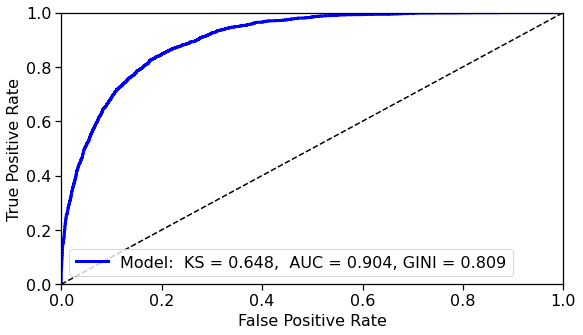

In [67]:
def plot_roc_curve(y, y_pred, gini, ks):
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = (15, 8)

    plt.plot(fpr, tpr, 'b', lw=3, 
             label='%s KS = %0.3f,  AUC = %0.3f, GINI = %0.3f' 
             % ('Model: ',ks, roc_auc, gini))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', size=16)
    plt.ylabel('True Positive Rate', size=16)
    plt.legend(loc=0, fontsize=16)
    plt.show()

fpr, tpr, thresholds = roc_curve(data['Target'], data['Prob'])
roc_auc = auc(fpr, tpr)
gini_ = 2 * roc_auc_score(data.Target.values, data.Prob.values) - 1

ks = stats.ks_2samp(data[data['Target'] == 0]['Prob'], 
                    data[data['Target'] == 1]['Prob']).statistic

print(f'KS = {ks :.3} -- AUC = {roc_auc :.3} -- GINI = {gini_ :.3}')

plot_roc_curve(data.Target.values, data.Prob.values, gini_, ks)

In [60]:
fpr, tpr, thresholds = roc_curve(data.Target.values, data.Prob.values)

precision,recall,pr_thresh = precision_recall_curve(data.Target.values, 
                                                    data.Prob.values)

f1_score = 2*precision*recall/(precision+recall)
f1_score = f1_score[:-1]
precision = precision[:-1]
recall = recall[:-1]
f1_score[np.isnan(f1_score)] = -1.0
bestF1 = np.argmax(f1_score)

print(f'O threshold do melhor F1: >>> {pr_thresh[bestF1] :.3} <<<')
print(f'   F1: {f1_score[bestF1] :.3} -- ', end='')
print(f'Precision: {precision[bestF1] :.3} -- ', end='')
print(f'Recall: {recall[bestF1] :.3}')

O threshold do melhor F1: >>> 0.319 <<<
   F1: 0.698 -- Precision: 0.627 -- Recall: 0.786


In [61]:
opt_idx = np.argmin(np.sqrt(np.square(1.0-tpr) + np.square(fpr)))
opt_threshold = thresholds[opt_idx]
print(f'O threshold do melhor F1: {pr_thresh[bestF1] :.3}')

y_hat_best_thres = (data.Prob.values >= pr_thresh[bestF1]).astype(int)
# y_hat_best_thres = (data.Prob.values >= 0.5).astype(int)

print(f'\nMatriz de confusão no thrs {pr_thresh[bestF1] :.3}:')
confusion_matrix(trues, y_hat_best_thres)

O threshold do melhor F1: 0.319

Matriz de confusão no thrs 0.319:


array([[6261, 1117],
       [ 512, 1879]])

O threshold do melhor F1: >>> 0.319 <<<
   F1: 0.698 -- Precision: 0.627 -- Recall: 0.786


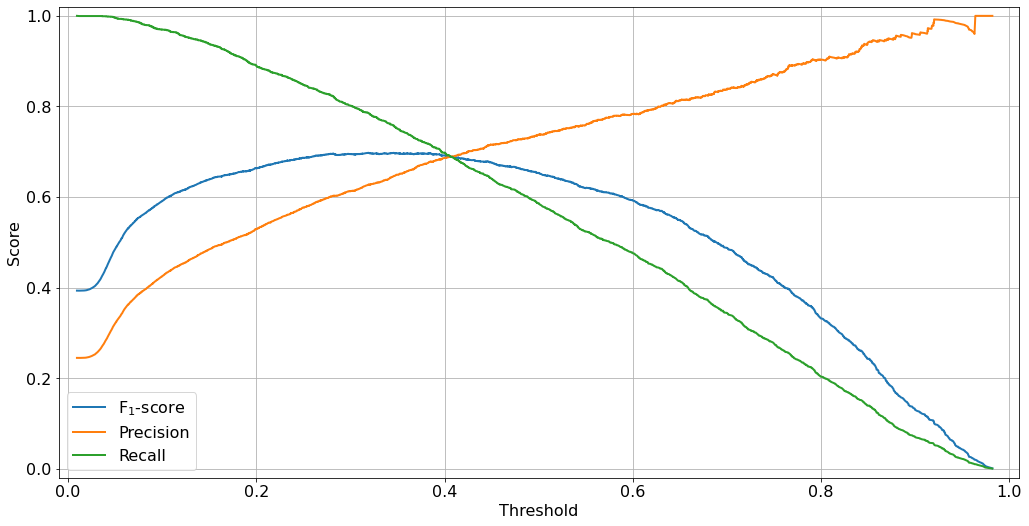

In [62]:
plt.rcParams.update({'font.size': 16})
plt.plot(pr_thresh,f1_score, lw=2)
plt.plot(pr_thresh,precision,  lw=2)
plt.plot(pr_thresh,recall, lw=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xticks(fontsize=16)
plt.xlim(-0.01, 1.01)
plt.ylim(-0.02, 1.02)
plt.yticks(fontsize=16)
plt.grid()
plt.legend(['F$_1$-score', 'Precision', 'Recall'],prop={'size': 16})
plt.tight_layout(2)
plt.savefig('precision-recall-thres', bbox_inches='tight')
print(f'O threshold do melhor F1: >>> {pr_thresh[bestF1] :.3} <<<')
print(f'   F1: {f1_score[bestF1] :.3} -- ', end='')
print(f'Precision: {precision[bestF1] :.3} -- ', end='')
print(f'Recall: {recall[bestF1] :.3}')

Negados: 2391 Aprovados: 7378


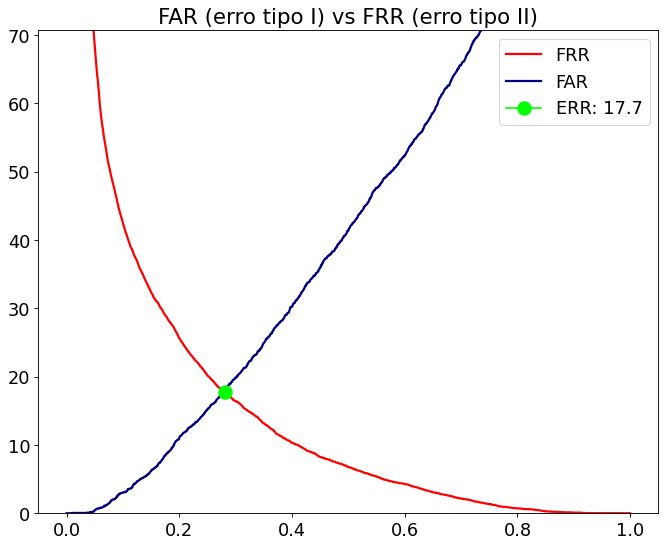

0.2816408204102051

In [63]:
_,Err_point = far_vs_frr(data.Target.values, data.Prob.values, steps=2000, fig=True)
Err_point

In [64]:
y_err = (data.Prob.values >= Err_point).astype(int)

print(f'\nMatriz de confusão no ponto do ERR {Err_point :.3}:')
confusion_matrix(trues, y_err)


Matriz de confusão no ponto do ERR 0.282:


array([[6080, 1298],
       [ 425, 1966]])

In [65]:
y_50 = (data.Prob.values >= 0.5).astype(int)

print(f'\nMatriz de confusão no threshold {0.50}:')
confusion_matrix(trues, y_50)


Matriz de confusão no threshold 0.5:


array([[6879,  499],
       [ 990, 1401]])

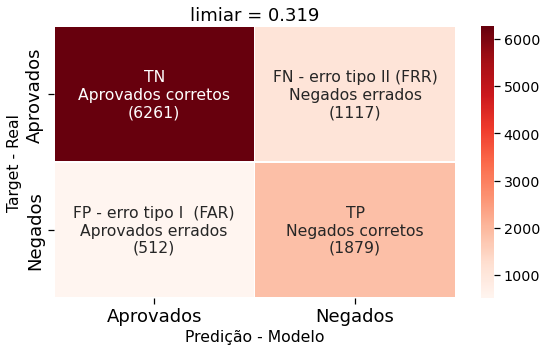

In [66]:
plt.rcParams['figure.figsize'] = (9, 5)

sns.set_context("notebook", font_scale=1.3)

confusao = confusion_matrix(trues, y_hat_best_thres)
group_names = ['TN\nAprovados corretos',
               'FN - erro tipo II (FRR)\nNegados errados', 
               'FP - erro tipo I  (FAR)\nAprovados errados',
               'TP\nNegados corretos']

group_counts = ['({0:0.0f})'.format(value) for value in
                confusao.flatten()]

group_percentages = ['{0:.1%}'.format(value) for value in
                     confusao.flatten()/np.sum(confusao)]

labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

cmap = 'Reds'#'binary'#'PuRd'#'jet'#'YlOrRd'#

ax = sns.heatmap(confusao, annot=labels, fmt='', square=False,
                 cmap=cmap, cbar=True, linewidths=0.7,
                )

ax.set_ylabel('Target - Real')
ax.set_xlabel('Predição - Modelo')
ax.set_xticklabels(['Aprovados','Negados'], va='center', 
                   rotation = 0, position=(0,-0.03), 
                   fontsize=18)
ax.set_yticklabels(['Aprovados','Negados'], 
                   va='center', rotation = 90, position=(0,0.28),
                   fontsize=18)
ax.set_title(f'limiar = {pr_thresh[bestF1] :.3}', fontsize=18)

#######
# Save
#######
plt.savefig('confusao.png', bbox_inches='tight')
plt.show()

# FIM
